**VISUALIZATION OF SeOT ALGORITHM ON TOY EXAMPLES**


PACKAGES

In [1]:
import os
import ot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from tqdm.auto import tqdm
import logging
from functools import partial
import torch
from src.barycenter_utils import set_seed
from src.wasserstein_barycenter_plans import WassersteinBarycenterPlan, wasserstein_barycenter
from src.spectral_embedding import SPEMB, adjacency_matrix___
from ot.da import SinkhornTransport, EMDTransport
from typing import Optional, Literal, Union
from functools import partial
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull
import matplotlib.patches as patches
from matplotlib.lines import Line2D
logging.getLogger('matplotlib.texmanager').setLevel(logging.WARNING)

SETTING THE PLOT PARAMETERS

In [2]:
def set_plot_params():
    plt.rcParams['font.size'] = 16
    params = {"ytick.color":"black",
            "xtick.color" : "black",
            "axes.labelcolor" : "black",
            "axes.edgecolor" : "black",
            "text.usetex" : True,
            "font.family" : "Serif",
            "font.serif" : ['Latin Modern Roman']}
    plt.rcParams.update(params)
set_plot_params()
np.random.seed(1)

CASE 1 : Single-Source SeOT

c:\Users\AS283669\AppData\Local\Programs\Python\Python310\lib\site-packages\ot\bregman\_sinkhorn.py:902: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\AS283669\AppData\Local\Programs\Python\Python310\lib\site-packages\ot\backend.py:1203: RuntimeWarning: overflow encountered in exp
  return np.exp(a)


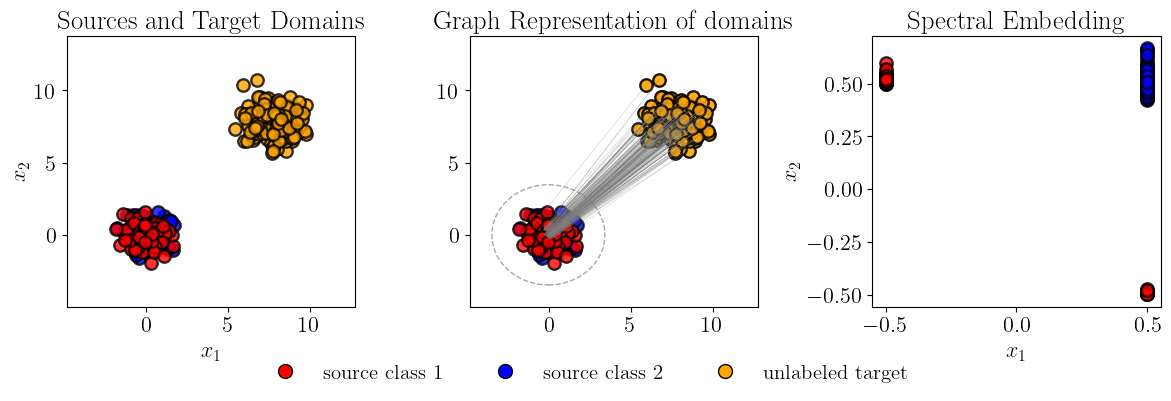

In [3]:
# -------------------------------
# 1. Data generation
# -------------------------------

np.random.seed(0)
n_samples = 100

cov1 = np.array([[0.5, 0.0], [0.0, 0.5]])
mean_src = np.array([0., 0.])
XP1 = np.random.multivariate_normal(mean_src, cov1, size=2*n_samples)
YP1 = np.concatenate([np.zeros(n_samples), np.ones(n_samples)])
perm = np.random.permutation(2*n_samples)
XP1 = XP1[perm]
YP1 = YP1[perm]

target_mean = np.array([8., 8.])
target_cov = np.array([[0.8, 0.0], [0.0, 0.8]])
XQ = np.random.multivariate_normal(target_mean, target_cov, size=2*n_samples)

all_points = np.vstack([XP1, XQ])
xmin, xmax = np.min(all_points[:, 0]), np.max(all_points[:, 0])
ymin, ymax = np.min(all_points[:, 1]), np.max(all_points[:, 1])

# -------------------------------
# 2. Algorithm params
# -------------------------------

algorithm = 'SeOT'  
seeds = [0]
numItermax = 500
reg_e = 1e-4
reg_e_bar = 1e-1
limit_max = 1e+3
StopThr = 1e-2

targets = [0]  
domains = [XP1, XQ]  
domain_labels = [YP1, None]  

barycenters = []

# -------------------------------
# 3. Running SEWP algorithm
# -------------------------------

for target in targets:
    sources = [0]  
    
    for seed in seeds:
        set_seed(seed)
        
        Xs = [domains[s] for s in sources]  
        ys = [domain_labels[s] for s in sources]  
        
        Xt = domains[1]  
        yt = None 
        
        if algorithm == 'SeOT':
            yb = np.concatenate(ys, axis=0)

            barycenter_solver = partial(
                wasserstein_barycenter,
                numItermax=numItermax,
                reg=reg_e_bar, limit_max=limit_max,
                stopThr=StopThr, ys=ys, ybar=yb, verbose=False
            )

            transport_solver = partial(
                SinkhornTransport,
                reg_e=reg_e,
                norm='max'
            )

            baryP = WassersteinBarycenterPlan(
                barycenter_solver=barycenter_solver,
                transport_solver=transport_solver,
                barycenter_initialization="random_cls"
            )

            Xbar, G_bar = baryP.fit(Xs=Xs, Xt=Xt, ys=ys, yt=None)
            #A_bar_ss = adjacency_matrix_single_source(G_bar=G_bar)
            A_bar = adjacency_matrix___(G_bar=G_bar)
            embedding, _ = SPEMB(
                adjacency=A_bar,
                n_components=2,
                eigen_solver='arpack',
                random_state=0,
                norm_laplacian=True,
                drop_first=False
            )
            
            barycenters.append((Xbar, yb, G_bar, A_bar))

Z = embedding
n_bar = len(Xbar)
n_s1 = len(XP1)

bar_idx = slice(0, n_bar)
s1_idx = slice(n_bar, n_bar + n_s1)

# -------------------------------
# 4. Visualization
# -------------------------------

plt.figure(figsize=(12, 4))  
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='source class 1',
           markerfacecolor='red', markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='source class 2',
           markerfacecolor='blue', markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='unlabeled target',
           markerfacecolor='orange', markersize=10, markeredgecolor='black')]

for i, (Xbar, yb, G_bar, A_bar) in enumerate(barycenters):
   
   # Subplot 1: Raw data points

    plt.subplot(1, 3, 1)  
    plt.scatter(XP1[YP1 == 0, 0], XP1[YP1 == 0, 1], alpha=0.8, label=None, 
                color='blue', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.scatter(XP1[YP1 == 1, 0], XP1[YP1 == 1, 1], alpha=0.8, label=None, 
                color='red', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.scatter(XQ[:, 0], XQ[:, 1], alpha=0.8, label=r'$Q$', 
                color='orange', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.xlim([xmin - 3, xmax + 3])
    plt.ylim([ymin - 3, ymax + 3])
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title('Sources and Target Domains')
    plt.grid(True, alpha=0.01)


    # Subplot 2: Barycenter + transport plans (graph representation of the domains)
    plt.subplot(1, 3, 2)  
    plt.scatter(XP1[YP1 == 0, 0], XP1[YP1 == 0, 1], alpha=0.8, label='Source - Class 0', 
                color='blue', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.scatter(XP1[YP1 == 1, 0], XP1[YP1 == 1, 1], alpha=0.8, label='Source - Class 1', 
                color='red', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.scatter(XQ[:, 0], XQ[:, 1], alpha=0.9, label='Target', 
                color='orange', marker='o', s=80, edgecolor='black', linewidth=1.7)

    if len(Xbar) > 0:
        center_x = np.mean(Xbar[:, 0])
        center_y = np.mean(Xbar[:, 1])
        distances = np.sqrt((Xbar[:, 0] - center_x)**2 + (Xbar[:, 1] - center_y)**2)
        radius = np.max(distances) * 3.0
        circle = plt.Circle((center_x, center_y), radius, color='grey', fill=False, 
                           linewidth=1, linestyle='--', alpha=0.7)
        plt.gca().add_patch(circle)

    bary_to_target = G_bar['barycenter_to_target']
    for bary_idx in range(len(Xbar)):
        max_target_idx = np.argmax(bary_to_target[bary_idx, :])
        max_strength = bary_to_target[bary_idx, max_target_idx]
        if max_strength > 1e-30:  
            bary_point = Xbar[bary_idx]
            target_point = Xt[max_target_idx]
            alpha = min(0.3, max_strength * 1e+4)  
            plt.plot([bary_point[0], target_point[0]], 
                     [bary_point[1], target_point[1]], 
                     'grey', alpha=alpha, linewidth=0.5)

    plt.xlim([xmin - 3, xmax + 3])
    plt.ylim([ymin - 3, ymax + 3])
    plt.xlabel(r'')
    plt.ylabel(r'')
    plt.title('Graph Representation of domains')
    plt.grid(True, alpha=0.01)


    # Subplot 3: Spectral embedding of the bipartite graph
    plt.subplot(1, 3, 3)  
    plt.scatter(Z[s1_idx, 0][YP1 == 0], Z[s1_idx, 1][YP1 == 0], 
                alpha=0.8, label='Source - Class 2', 
                color='blue', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.scatter(Z[s1_idx, 0][YP1 == 1], Z[s1_idx, 1][YP1 == 1], 
                alpha=0.8, label='Source - Class 1', 
                color='red', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title('Spectral Embedding')
    plt.grid(True, alpha=0.01)

plt.tight_layout()
plt.gcf().legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=15, frameon=False, bbox_to_anchor=(0.5, -0.04))
plt.show()


CASE 2 : Multi-Source SeOT

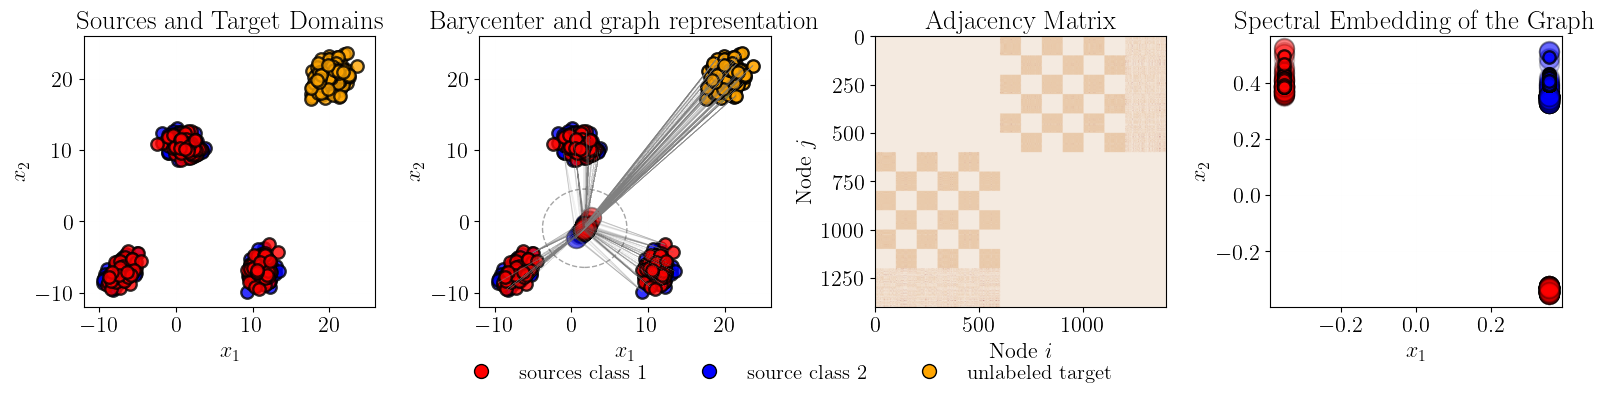

In [4]:
np.random.seed(0)

#===============================Generate data for multisource=================================

n_samples = 100

cov1 = np.array([[1., 0.5], [0.5, 1.]])
cov2 = np.array([[1.2, -0.3], [-0.3, 0.8]])
cov3 = np.array([[0.8, 0.2], [0.2, 1.5]])

mean1 = np.array([-7., -7.])  
mean2 = np.array([1., 11.])   
mean3 = np.array([11., -7.])  

XP1 = np.random.multivariate_normal(mean1, cov1, size=2*n_samples)  
XP2 = np.random.multivariate_normal(mean2, cov2, size=2*n_samples)  
XP3 = np.random.multivariate_normal(mean3, cov3, size=2*n_samples)  

YP1 = np.concatenate([np.zeros(n_samples), np.ones(n_samples)])  
YP2 = np.concatenate([np.zeros(n_samples), np.ones(n_samples)])  
YP3 = np.concatenate([np.zeros(n_samples), np.ones(n_samples)])  

target_mean = np.array([20., 20.])  
target_cov = np.array([[1.5, 0.4], [0.4, 1.5]])
XQ = np.random.multivariate_normal(target_mean, target_cov, size=2*n_samples)


all_source_points = np.vstack([XP1, XP2, XP3])
all_points = np.vstack([all_source_points, XQ])
xmin, xmax = int(np.min(all_points[:, 0])), int(np.max(all_points[:, 0]))
ymin, ymax = int(np.min(all_points[:, 1])), int(np.max(all_points[:, 1]))

# ====================================Custom colormap====================================
colors = [
    (0.96, 0.92, 0.88),  
    (0.9, 0.75, 0.6),    
    (0.8, 0.4, 0.3),     
    (0.5, 0.1, 0.1)   
]
cmap_custom = LinearSegmentedColormap.from_list("beige_bordeaux", colors)

#================================SEOT Hyperparameters=====================================
algorithm = 'SeOT'  
seeds = [0]
numItermax = 500
reg_e = 1e-4
reg_e_bar = 1e-2
limit_max = 1e+3
StopThr = 1e-2

targets = [0]  
domains = [XP1, XP2, XP3, XQ]  
domain_labels = [YP1, YP2, YP3, None]  
barycenters = []

#==========================================Run SeOT========================================

for target in targets:
    sources = [0, 1, 2]
    
    for seed in seeds:
        set_seed(seed)
        
        Xs = [domains[s] for s in sources]  
        ys = [domain_labels[s] for s in sources]  
        
        Xt = domains[3]  
        yt = None 
        
        if algorithm == 'SeOT':
            yb = np.concatenate(ys, axis=0)

            barycenter_solver = partial(
                wasserstein_barycenter,
                numItermax=numItermax,
                reg=reg_e_bar, limit_max=limit_max,
                stopThr=StopThr, ys=ys, ybar=yb, verbose=False
            )

            transport_solver = partial(
                SinkhornTransport,
                reg_e=reg_e,
                norm='max'
            )

            baryP = WassersteinBarycenterPlan(
                barycenter_solver=barycenter_solver,
                transport_solver=transport_solver,
                barycenter_initialization="random_cls"
            )

            Xbar, G_bar = baryP.fit(Xs=Xs, Xt=Xt, ys=ys, yt=None)
            A_bar = adjacency_matrix___(G_bar=G_bar)

            embedding, _ = SPEMB(
                adjacency=A_bar,
                n_components=2,
                eigen_solver='arpack',
                random_state=0,
                norm_laplacian=True,
                drop_first=False
            )
            
            barycenters.append((Xbar, yb, G_bar, A_bar))

Z = embedding

#====================================Get indices for slicing Z========================================

n_bar = len(Xbar)
n_s1 = len(XP1)
n_s2 = len(XP2)
n_s3 = len(XP3)

bar_idx = slice(0, n_bar)
s1_idx = slice(n_bar, n_bar + n_s1)
s2_idx = slice(n_bar + n_s1, n_bar + n_s1 + n_s2)
s3_idx = slice(n_bar + n_s1 + n_s2, n_bar + n_s1 + n_s2 + n_s3)

class0_points = np.vstack([
Z[bar_idx][yb == 0],
Z[s1_idx][YP1 == 0],
Z[s2_idx][YP2 == 0],
Z[s3_idx][YP3 == 0]
])

class1_points = np.vstack([
Z[bar_idx][yb == 1],
Z[s1_idx][YP1 == 1],
Z[s2_idx][YP2 == 1],
Z[s3_idx][YP3 == 1]
])

#================================================Plotting================================================
plt.figure(figsize=(16, 4))  
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='sources class 1',
           markerfacecolor='red', markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='source class 2',
           markerfacecolor='blue', markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='unlabeled target',
           markerfacecolor='orange', markersize=10, markeredgecolor='black')
]



for i, (Xbar, yb, G_bar, A_bar) in enumerate(barycenters):
   
    # Subplot 1: Raw data points

    plt.subplot(1, 4, 1)  
    
    plt.scatter(XP1[YP1 == 0, 0], XP1[YP1 == 0, 1], alpha=0.8, label=None, 
                color='blue', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.scatter(XP1[YP1 == 1, 0], XP1[YP1 == 1, 1], alpha=0.8, label=None, 
                color='red', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.scatter(XP2[YP2 == 0, 0], XP2[YP2 == 0, 1], alpha=0.8, label=None, 
                color='blue', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.scatter(XP2[YP2 == 1, 0], XP2[YP2 == 1, 1], alpha=0.8, label=None, 
                color='red', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.scatter(XP3[YP3 == 0, 0], XP3[YP3 == 0, 1], alpha=0.8, label=None, 
                color='blue', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.scatter(XP3[YP3 == 1, 0], XP3[YP3 == 1, 1], alpha=0.8, label=None, 
                color='red', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.scatter(XQ[:, 0], XQ[:, 1], alpha=0.8, label=r'$Q$', 
                color='orange', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.xlim([xmin - 3, xmax + 3])
    plt.ylim([ymin - 3, ymax + 3])
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title('Sources and Target Domains')
    plt.grid(True, alpha=0.01)



    # Subplot 2: Barycenter + transport plans (graph representation of the domains)
    plt.subplot(1, 4, 2)  
    
    plt.scatter(XP1[YP1 == 0, 0], XP1[YP1 == 0, 1], alpha=0.8, label='Source 1 - Class 0', 
                color='blue', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.scatter(XP1[YP1 == 1, 0], XP1[YP1 == 1, 1], alpha=0.8, label='Source 1 - Class 1', 
                color='red', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.scatter(XP2[YP2 == 0, 0], XP2[YP2 == 0, 1], alpha=0.8, label='Source 2 - Class 0', 
                color='blue', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.scatter(XP2[YP2 == 1, 0], XP2[YP2 == 1, 1], alpha=0.8, label='Source 2 - Class 1', 
                color='red', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.scatter(XP3[YP3 == 0, 0], XP3[YP3 == 0, 1], alpha=0.8, label='Source 3 - Class 0', 
                color='blue', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.scatter(XP3[YP3 == 1, 0], XP3[YP3 == 1, 1], alpha=0.8, label='Source 3 - Class 1', 
                color='red', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.scatter(XQ[:, 0], XQ[:, 1], alpha=0.9, label='Target', 
                color='orange', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.scatter(Xbar[yb == 0, 0], Xbar[yb == 0, 1], alpha=0.2, 
                label=f'Barycenter - Class 0', 
                color='blue', marker='o', s=200, edgecolor='black', linewidth=1.2)
    plt.scatter(Xbar[yb == 1, 0], Xbar[yb == 1, 1], alpha=0.2, 
                label=f'Barycenter - Class 1', 
                color='red', marker='o', s=200, edgecolor='black', linewidth=1.2)

    if len(Xbar) > 0:
        center_x = np.mean(Xbar[:, 0])
        center_y = np.mean(Xbar[:, 1])
        distances = np.sqrt((Xbar[:, 0] - center_x)**2 + (Xbar[:, 1] - center_y)**2)
        radius = np.max(distances) * 3.0
        circle = plt.Circle((center_x, center_y), radius, color='grey', fill=False, 
                           linewidth=1, linestyle='--', alpha=0.7)
        plt.gca().add_patch(circle)

    source_to_bary = G_bar['source_to_barycenter']
    for j, coupling_key in enumerate(source_to_bary.keys()):
        coupling_matrix = source_to_bary[coupling_key]
        source_points = Xs[j]  
        for bary_idx in range(len(Xbar)):
            max_source_idx = np.argmax(coupling_matrix[:, bary_idx])
            max_strength = coupling_matrix[max_source_idx, bary_idx]
            if max_strength > 1e-15: 
                source_point = source_points[max_source_idx]
                bary_point = Xbar[bary_idx]
                alpha = min(0.3, max_strength * 1000)
                plt.plot([source_point[0], bary_point[0]], 
                         [source_point[1], bary_point[1]], 
                         'gray', alpha=alpha, linewidth=0.5)

    bary_to_target = G_bar['barycenter_to_target']
    for bary_idx in range(len(Xbar)):
        max_target_idx = np.argmax(bary_to_target[bary_idx, :])
        max_strength = bary_to_target[bary_idx, max_target_idx]
        if max_strength > 1e-15:  
            bary_point = Xbar[bary_idx]
            target_point = Xt[max_target_idx]
            alpha = min(0.3, max_strength * 1000)  
            plt.plot([bary_point[0], target_point[0]], 
                     [bary_point[1], target_point[1]], 
                     'grey', alpha=alpha, linewidth=0.5)

    plt.xlim([xmin - 3, xmax + 3])
    plt.ylim([ymin - 3, ymax + 3])
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title('Barycenter and graph representation')
    plt.grid(True, alpha=0.01)

    ## Subplot 3: Constructed Adjacency matrix using the ot plans
    plt.subplot(1, 4, 3)  
    plt.imshow(A_bar, cmap=cmap_custom, aspect='auto', vmin=np.min(A_bar), vmax=np.max(A_bar)*0.05)
    plt.xlabel('Node $i$')
    plt.ylabel('Node $j$')
    plt.title('Adjacency Matrix')

    # Subplot 4: Spectral embedding of the star graph
    plt.subplot(1, 4, 4)  
    plt.scatter(Z[bar_idx, 0][yb == 0], Z[bar_idx, 1][yb == 0], 
                alpha=0.2, label='Barycenter - Class 0', 
                color='blue', marker='o', s=200, edgecolor='black', linewidth=1.2)

    plt.scatter(Z[bar_idx, 0][yb == 1], Z[bar_idx, 1][yb == 1], 
                alpha=0.2, label='Barycenter - Class 1', 
                color='red', marker='o', s=200, edgecolor='black', linewidth=1.2)

    plt.scatter(Z[s1_idx, 0][YP1 == 0], Z[s1_idx, 1][YP1 == 0], 
                alpha=0.8, label='Source 1 - Class 0', 
                color='blue', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.scatter(Z[s1_idx, 0][YP1 == 1], Z[s1_idx, 1][YP1 == 1], 
                alpha=0.8, label='Source 1 - Class 1', 
                color='red', marker='o', s=80, edgecolor='black', linewidth=1.7)

    plt.scatter(Z[s2_idx, 0][YP2 == 0], Z[s2_idx, 1][YP2 == 0], 
                alpha=0.8, label='Source 2 - Class 0', 
                color='blue', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.scatter(Z[s2_idx, 0][YP2 == 1], Z[s2_idx, 1][YP2 == 1], 
                alpha=0.8, label='Source 2 - Class 1', 
                color='red', marker='o', s=80, edgecolor='black', linewidth=1.7)

    plt.scatter(Z[s3_idx, 0][YP3 == 0], Z[s3_idx, 1][YP3 == 0], 
                alpha=0.8, label='Source 3 - Class 0', 
                color='blue', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.scatter(Z[s3_idx, 0][YP3 == 1], Z[s3_idx, 1][YP3 == 1], 
                alpha=0.8, label='Source 3 - Class 1', 
                color='red', marker='o', s=80, edgecolor='black', linewidth=1.7)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title('Spectral Embedding of the Graph')
    plt.grid(True, alpha=0.01)

plt.tight_layout()
plt.gcf().legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=15, frameon=False, bbox_to_anchor=(0.5, -0.04) )
plt.show()